In [1]:
# General libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Neural network libraries
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow import keras

# Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Embedding
from keras.layers.recurrent import LSTM
#Visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt


['Volume IBM', 'Volume GOLD', 'Volume NSQ', 'Volume WTI', 'SO IBM',
       'CCI IBM', 'RSI IBM', 'ULTOSC IBM', 'CCI WTI', 'CCI GOLD',
       'aroonup GOLD', 'ULTOSC GOLD', 'SO NSQ', 'CCI NSQ', 'aroondown NSQ',
       'aroonup NSQ', 'ULTOSC NSQ']

## Preliminary work on the dataset

In [2]:
yahoo_df = pd.read_csv("../data/IBM.csv")
#yahoo_df = yahoo_df.set_index("Date")
yahoo_df = yahoo_df.set_index("Date")

### Cleaning

In [3]:

X = yahoo_df[['ROC_4', 'ROC_5', 'ROC_6', '4 Day ROI', '6 Day ROI', '30 Day ROI',
       'RSI_3', 'RSI_4', 'CCI']]
#X = yahoo_df.drop(columns=["Up down"])

y = yahoo_df["Up down"]



In [4]:
X

,ROC_4,ROC_5,ROC_6,4 Day ROI,6 Day ROI,30 Day ROI,RSI_3,RSI_4,CCI
Date,,,,,,,,,
2000-12-29,-4.494388,4.214552,-1.162792,-0.044944,-0.011628,-0.144654,41.370961,40.642850,-77.323805
2001-01-02,0.000000,-4.705060,3.984670,0.000000,0.039847,-0.136768,40.095325,39.796820,-68.964816
2001-01-03,11.734311,11.569637,6.320219,0.117343,0.063202,-0.071735,80.992021,74.508975,6.359477
2001-01-04,9.310851,10.036894,9.874722,0.093109,0.098747,-0.097458,71.462470,67.393286,74.412839
2001-01-05,10.588240,10.263934,10.996307,0.105882,0.109963,-0.045685,73.786841,69.454321,51.328590
...,...,...,...,...,...,...,...,...,...
2022-03-24,0.380557,1.008128,1.739609,0.003806,0.017396,-0.061978,70.864721,69.687439,93.469804
2022-03-25,2.537080,2.011503,2.649271,0.025371,0.026493,-0.016252,83.656363,80.772498,131.060998
2022-03-28,1.867351,2.630753,2.104696,0.018674,0.021047,-0.009194,84.185354,81.261931,121.945084


In [5]:
X.columns

Index(['ROC_4', 'ROC_5', 'ROC_6', '4 Day ROI', '6 Day ROI', '30 Day ROI',
       'RSI_3', 'RSI_4', 'CCI'],
      dtype='object')

In [6]:
def normalize(df):
    #df = data
    for column in df:
        df[column]=((df[column]-df[column].mean())/df[column].std())
    return df

# Train, test, val

In [7]:
# Split in 80/20 the dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20, shuffle=False)

In [8]:
X_train = normalize(X_train).values
X_test = normalize(X_test).values

# Normalize

In [9]:
y_train = y_train.values
y_test = y_test.values

In [10]:
#X_train = normalize(X_train)
#X_test = normalize(X_test)

In [11]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# Model

In [12]:
def model_(X,optimizer,activation,loss,metrics):
    #optimizer=str(optimizer)
    #activation=str(activation)
    #loss=str(loss)
    # Define the Model

    # Instantiate the Sequential Model
    model = Sequential()
    model.add(LSTM(units=512, activation="sigmoid",return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=256, activation="sigmoid",return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=128, activation="sigmoid",return_sequences=False))
    model.add(Dropout(0.4))
    # Add a Dense layer
    model.add(Dense(64, activation="sigmoid"))
    # Add the output layer
    model.add(Dense(1, activation="sigmoid"))

    # Compiling the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [13]:
# Define the Model
metrics=[
    keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.49),
    keras.metrics.BinaryCrossentropy(),
    ]

esm = EarlyStopping(monitor = 'val_binary_accuracy',patience=50)
# Set the optimizer
opt = keras.optimizers.Adam(learning_rate = 0.001)

In [14]:
batch_size = int(round(X_train.shape[0]*0.1))
# # Training the model to the training dataset
model=model_(X_train, opt,'relu','binary_crossentropy',metrics) 
history=model.fit(X_train, y_train, batch_size= batch_size, epochs=1000, verbose=1, shuffle=False,validation_split=0.10)

Epoch 1/1000
9/9 [==============================] - 12s 307ms/step - loss: 0.7227 - binary_accuracy: 0.4899 - binary_crossentropy: 0.7227 - val_loss: 0.7225 - val_binary_accuracy: 0.4673 - val_binary_crossentropy: 0.7225
Epoch 2/1000
9/9 [==============================] - 1s 154ms/step - loss: 0.7020 - binary_accuracy: 0.5281 - binary_crossentropy: 0.7020 - val_loss: 0.7100 - val_binary_accuracy: 0.4673 - val_binary_crossentropy: 0.7100
Epoch 3/1000
9/9 [==============================] - 1s 160ms/step - loss: 0.6952 - binary_accuracy: 0.5151 - binary_crossentropy: 0.6952 - val_loss: 0.6933 - val_binary_accuracy: 0.4673 - val_binary_crossentropy: 0.6933
Epoch 4/1000
9/9 [==============================] - 1s 153ms/step - loss: 0.6940 - binary_accuracy: 0.5101 - binary_crossentropy: 0.6940 - val_loss: 0.6974 - val_binary_accuracy: 0.4673 - val_binary_crossentropy: 0.6974
Epoch 5/1000
9/9 [==============================] - 1s 97ms/step - loss: 0.6924 - binary_accuracy: 0.5260 - binary_cros

9/9 [==============================] - 1s 74ms/step - loss: 0.6911 - binary_accuracy: 0.5283 - binary_crossentropy: 0.6911 - val_loss: 0.7007 - val_binary_accuracy: 0.4650 - val_binary_crossentropy: 0.7007
Epoch 39/1000
9/9 [==============================] - 1s 69ms/step - loss: 0.6910 - binary_accuracy: 0.5257 - binary_crossentropy: 0.6910 - val_loss: 0.7011 - val_binary_accuracy: 0.4626 - val_binary_crossentropy: 0.7011
Epoch 40/1000
9/9 [==============================] - 1s 74ms/step - loss: 0.6909 - binary_accuracy: 0.5348 - binary_crossentropy: 0.6909 - val_loss: 0.7006 - val_binary_accuracy: 0.4650 - val_binary_crossentropy: 0.7006
Epoch 41/1000
9/9 [==============================] - 1s 76ms/step - loss: 0.6912 - binary_accuracy: 0.5307 - binary_crossentropy: 0.6912 - val_loss: 0.7008 - val_binary_accuracy: 0.4650 - val_binary_crossentropy: 0.7008
Epoch 42/1000
9/9 [==============================] - 1s 86ms/step - loss: 0.6906 - binary_accuracy: 0.5333 - binary_crossentropy: 0.69

9/9 [==============================] - 1s 72ms/step - loss: 0.6900 - binary_accuracy: 0.5322 - binary_crossentropy: 0.6900 - val_loss: 0.7007 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7007
Epoch 76/1000
9/9 [==============================] - 1s 67ms/step - loss: 0.6895 - binary_accuracy: 0.5377 - binary_crossentropy: 0.6895 - val_loss: 0.7013 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7013
Epoch 77/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6905 - binary_accuracy: 0.5335 - binary_crossentropy: 0.6905 - val_loss: 0.7007 - val_binary_accuracy: 0.4696 - val_binary_crossentropy: 0.7007
Epoch 78/1000
9/9 [==============================] - 1s 76ms/step - loss: 0.6903 - binary_accuracy: 0.5379 - binary_crossentropy: 0.6903 - val_loss: 0.7007 - val_binary_accuracy: 0.4720 - val_binary_crossentropy: 0.7007
Epoch 79/1000
9/9 [==============================] - 1s 78ms/step - loss: 0.6903 - binary_accuracy: 0.5333 - binary_crossentropy: 0.69

9/9 [==============================] - 1s 72ms/step - loss: 0.6896 - binary_accuracy: 0.5317 - binary_crossentropy: 0.6896 - val_loss: 0.7005 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7005
Epoch 113/1000
9/9 [==============================] - 1s 69ms/step - loss: 0.6894 - binary_accuracy: 0.5398 - binary_crossentropy: 0.6894 - val_loss: 0.7012 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7012
Epoch 114/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.6897 - binary_accuracy: 0.5275 - binary_crossentropy: 0.6897 - val_loss: 0.7010 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7010
Epoch 115/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6902 - binary_accuracy: 0.5403 - binary_crossentropy: 0.6902 - val_loss: 0.7009 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7009
Epoch 116/1000
9/9 [==============================] - 1s 83ms/step - loss: 0.6902 - binary_accuracy: 0.5392 - binary_crossentropy: 

9/9 [==============================] - 1s 75ms/step - loss: 0.6898 - binary_accuracy: 0.5322 - binary_crossentropy: 0.6898 - val_loss: 0.7006 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7006
Epoch 150/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.6891 - binary_accuracy: 0.5421 - binary_crossentropy: 0.6891 - val_loss: 0.7011 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7011
Epoch 151/1000
9/9 [==============================] - 1s 79ms/step - loss: 0.6881 - binary_accuracy: 0.5374 - binary_crossentropy: 0.6881 - val_loss: 0.7009 - val_binary_accuracy: 0.4813 - val_binary_crossentropy: 0.7009
Epoch 152/1000
9/9 [==============================] - 1s 81ms/step - loss: 0.6888 - binary_accuracy: 0.5351 - binary_crossentropy: 0.6888 - val_loss: 0.7013 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7013
Epoch 153/1000
9/9 [==============================] - 1s 86ms/step - loss: 0.6894 - binary_accuracy: 0.5333 - binary_crossentropy: 

9/9 [==============================] - 1s 72ms/step - loss: 0.6890 - binary_accuracy: 0.5369 - binary_crossentropy: 0.6890 - val_loss: 0.7010 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7010
Epoch 187/1000
9/9 [==============================] - 1s 86ms/step - loss: 0.6887 - binary_accuracy: 0.5408 - binary_crossentropy: 0.6887 - val_loss: 0.7008 - val_binary_accuracy: 0.4813 - val_binary_crossentropy: 0.7008
Epoch 188/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6883 - binary_accuracy: 0.5418 - binary_crossentropy: 0.6883 - val_loss: 0.7008 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7008
Epoch 189/1000
9/9 [==============================] - 1s 71ms/step - loss: 0.6883 - binary_accuracy: 0.5429 - binary_crossentropy: 0.6883 - val_loss: 0.7012 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7012
Epoch 190/1000
9/9 [==============================] - 1s 81ms/step - loss: 0.6892 - binary_accuracy: 0.5372 - binary_crossentropy: 

9/9 [==============================] - 1s 76ms/step - loss: 0.6884 - binary_accuracy: 0.5413 - binary_crossentropy: 0.6884 - val_loss: 0.7020 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7020
Epoch 224/1000
9/9 [==============================] - 1s 76ms/step - loss: 0.6888 - binary_accuracy: 0.5439 - binary_crossentropy: 0.6888 - val_loss: 0.7014 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7014
Epoch 225/1000
9/9 [==============================] - 1s 80ms/step - loss: 0.6887 - binary_accuracy: 0.5457 - binary_crossentropy: 0.6887 - val_loss: 0.7011 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7011
Epoch 226/1000
9/9 [==============================] - 1s 68ms/step - loss: 0.6881 - binary_accuracy: 0.5434 - binary_crossentropy: 0.6881 - val_loss: 0.7013 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7013
Epoch 227/1000
9/9 [==============================] - 1s 76ms/step - loss: 0.6890 - binary_accuracy: 0.5405 - binary_crossentropy: 

9/9 [==============================] - 1s 76ms/step - loss: 0.6883 - binary_accuracy: 0.5450 - binary_crossentropy: 0.6883 - val_loss: 0.7019 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7019
Epoch 261/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.6884 - binary_accuracy: 0.5408 - binary_crossentropy: 0.6884 - val_loss: 0.7030 - val_binary_accuracy: 0.4813 - val_binary_crossentropy: 0.7030
Epoch 262/1000
9/9 [==============================] - 1s 80ms/step - loss: 0.6881 - binary_accuracy: 0.5424 - binary_crossentropy: 0.6881 - val_loss: 0.7016 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7016
Epoch 263/1000
9/9 [==============================] - 1s 74ms/step - loss: 0.6878 - binary_accuracy: 0.5434 - binary_crossentropy: 0.6878 - val_loss: 0.7016 - val_binary_accuracy: 0.4813 - val_binary_crossentropy: 0.7016
Epoch 264/1000
9/9 [==============================] - 1s 71ms/step - loss: 0.6884 - binary_accuracy: 0.5499 - binary_crossentropy: 

9/9 [==============================] - 1s 94ms/step - loss: 0.6878 - binary_accuracy: 0.5437 - binary_crossentropy: 0.6878 - val_loss: 0.7020 - val_binary_accuracy: 0.4720 - val_binary_crossentropy: 0.7020
Epoch 298/1000
9/9 [==============================] - 1s 69ms/step - loss: 0.6870 - binary_accuracy: 0.5502 - binary_crossentropy: 0.6870 - val_loss: 0.7020 - val_binary_accuracy: 0.4930 - val_binary_crossentropy: 0.7020
Epoch 299/1000
9/9 [==============================] - 1s 83ms/step - loss: 0.6879 - binary_accuracy: 0.5499 - binary_crossentropy: 0.6879 - val_loss: 0.7029 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7029
Epoch 300/1000
9/9 [==============================] - 1s 100ms/step - loss: 0.6889 - binary_accuracy: 0.5418 - binary_crossentropy: 0.6889 - val_loss: 0.7022 - val_binary_accuracy: 0.4813 - val_binary_crossentropy: 0.7022
Epoch 301/1000
9/9 [==============================] - 1s 93ms/step - loss: 0.6886 - binary_accuracy: 0.5418 - binary_crossentropy:

9/9 [==============================] - 1s 72ms/step - loss: 0.6885 - binary_accuracy: 0.5395 - binary_crossentropy: 0.6885 - val_loss: 0.7018 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7018
Epoch 335/1000
9/9 [==============================] - 1s 78ms/step - loss: 0.6875 - binary_accuracy: 0.5390 - binary_crossentropy: 0.6875 - val_loss: 0.7018 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7018
Epoch 336/1000
9/9 [==============================] - 1s 85ms/step - loss: 0.6868 - binary_accuracy: 0.5517 - binary_crossentropy: 0.6868 - val_loss: 0.7028 - val_binary_accuracy: 0.4743 - val_binary_crossentropy: 0.7028
Epoch 337/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6878 - binary_accuracy: 0.5494 - binary_crossentropy: 0.6878 - val_loss: 0.7029 - val_binary_accuracy: 0.4743 - val_binary_crossentropy: 0.7029
Epoch 338/1000
9/9 [==============================] - 1s 80ms/step - loss: 0.6877 - binary_accuracy: 0.5450 - binary_crossentropy: 

9/9 [==============================] - 2s 224ms/step - loss: 0.6870 - binary_accuracy: 0.5470 - binary_crossentropy: 0.6870 - val_loss: 0.7036 - val_binary_accuracy: 0.4720 - val_binary_crossentropy: 0.7036
Epoch 372/1000
9/9 [==============================] - 2s 244ms/step - loss: 0.6876 - binary_accuracy: 0.5413 - binary_crossentropy: 0.6876 - val_loss: 0.7031 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7031
Epoch 373/1000
9/9 [==============================] - 2s 205ms/step - loss: 0.6875 - binary_accuracy: 0.5473 - binary_crossentropy: 0.6875 - val_loss: 0.7021 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7021
Epoch 374/1000
9/9 [==============================] - 2s 184ms/step - loss: 0.6873 - binary_accuracy: 0.5473 - binary_crossentropy: 0.6873 - val_loss: 0.7028 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7028
Epoch 375/1000
9/9 [==============================] - 1s 74ms/step - loss: 0.6865 - binary_accuracy: 0.5439 - binary_crossentro

9/9 [==============================] - 1s 65ms/step - loss: 0.6878 - binary_accuracy: 0.5429 - binary_crossentropy: 0.6878 - val_loss: 0.7022 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7022
Epoch 409/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6875 - binary_accuracy: 0.5444 - binary_crossentropy: 0.6875 - val_loss: 0.7019 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7019
Epoch 410/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6874 - binary_accuracy: 0.5465 - binary_crossentropy: 0.6874 - val_loss: 0.7029 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7029
Epoch 411/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.6872 - binary_accuracy: 0.5465 - binary_crossentropy: 0.6872 - val_loss: 0.7028 - val_binary_accuracy: 0.4720 - val_binary_crossentropy: 0.7028
Epoch 412/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6869 - binary_accuracy: 0.5395 - binary_crossentropy: 

9/9 [==============================] - 1s 61ms/step - loss: 0.6881 - binary_accuracy: 0.5421 - binary_crossentropy: 0.6881 - val_loss: 0.7029 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7029
Epoch 446/1000
9/9 [==============================] - 1s 61ms/step - loss: 0.6863 - binary_accuracy: 0.5489 - binary_crossentropy: 0.6863 - val_loss: 0.7031 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7031
Epoch 447/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.6862 - binary_accuracy: 0.5496 - binary_crossentropy: 0.6862 - val_loss: 0.7034 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7034
Epoch 448/1000
9/9 [==============================] - 1s 68ms/step - loss: 0.6868 - binary_accuracy: 0.5476 - binary_crossentropy: 0.6868 - val_loss: 0.7039 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7039
Epoch 449/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.6876 - binary_accuracy: 0.5473 - binary_crossentropy: 

9/9 [==============================] - 1s 61ms/step - loss: 0.6867 - binary_accuracy: 0.5429 - binary_crossentropy: 0.6867 - val_loss: 0.7038 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7038
Epoch 483/1000
9/9 [==============================] - 1s 61ms/step - loss: 0.6863 - binary_accuracy: 0.5489 - binary_crossentropy: 0.6863 - val_loss: 0.7052 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7052
Epoch 484/1000
9/9 [==============================] - 1s 73ms/step - loss: 0.6879 - binary_accuracy: 0.5431 - binary_crossentropy: 0.6879 - val_loss: 0.7042 - val_binary_accuracy: 0.4720 - val_binary_crossentropy: 0.7042
Epoch 485/1000
9/9 [==============================] - 1s 83ms/step - loss: 0.6875 - binary_accuracy: 0.5408 - binary_crossentropy: 0.6875 - val_loss: 0.7021 - val_binary_accuracy: 0.4696 - val_binary_crossentropy: 0.7021
Epoch 486/1000
9/9 [==============================] - 1s 88ms/step - loss: 0.6873 - binary_accuracy: 0.5392 - binary_crossentropy: 

9/9 [==============================] - 1s 77ms/step - loss: 0.6859 - binary_accuracy: 0.5473 - binary_crossentropy: 0.6859 - val_loss: 0.7053 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7053
Epoch 520/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6854 - binary_accuracy: 0.5418 - binary_crossentropy: 0.6854 - val_loss: 0.7043 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7043
Epoch 521/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6866 - binary_accuracy: 0.5437 - binary_crossentropy: 0.6866 - val_loss: 0.7043 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7043
Epoch 522/1000
9/9 [==============================] - 1s 76ms/step - loss: 0.6853 - binary_accuracy: 0.5465 - binary_crossentropy: 0.6853 - val_loss: 0.7048 - val_binary_accuracy: 0.4720 - val_binary_crossentropy: 0.7048
Epoch 523/1000
9/9 [==============================] - 1s 82ms/step - loss: 0.6849 - binary_accuracy: 0.5455 - binary_crossentropy: 

9/9 [==============================] - 2s 182ms/step - loss: 0.6857 - binary_accuracy: 0.5455 - binary_crossentropy: 0.6857 - val_loss: 0.7048 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7048
Epoch 557/1000
9/9 [==============================] - 2s 169ms/step - loss: 0.6863 - binary_accuracy: 0.5421 - binary_crossentropy: 0.6863 - val_loss: 0.7052 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7052
Epoch 558/1000
9/9 [==============================] - 2s 180ms/step - loss: 0.6859 - binary_accuracy: 0.5517 - binary_crossentropy: 0.6859 - val_loss: 0.7050 - val_binary_accuracy: 0.4790 - val_binary_crossentropy: 0.7050
Epoch 559/1000
9/9 [==============================] - 2s 177ms/step - loss: 0.6866 - binary_accuracy: 0.5444 - binary_crossentropy: 0.6866 - val_loss: 0.7043 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7043
Epoch 560/1000
9/9 [==============================] - 2s 195ms/step - loss: 0.6859 - binary_accuracy: 0.5421 - binary_crossentr

9/9 [==============================] - 1s 64ms/step - loss: 0.6865 - binary_accuracy: 0.5450 - binary_crossentropy: 0.6865 - val_loss: 0.7060 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7060
Epoch 594/1000
9/9 [==============================] - 1s 71ms/step - loss: 0.6849 - binary_accuracy: 0.5494 - binary_crossentropy: 0.6849 - val_loss: 0.7060 - val_binary_accuracy: 0.4743 - val_binary_crossentropy: 0.7060
Epoch 595/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6855 - binary_accuracy: 0.5473 - binary_crossentropy: 0.6855 - val_loss: 0.7061 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7061
Epoch 596/1000
9/9 [==============================] - 1s 67ms/step - loss: 0.6861 - binary_accuracy: 0.5452 - binary_crossentropy: 0.6861 - val_loss: 0.7066 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7066
Epoch 597/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6866 - binary_accuracy: 0.5408 - binary_crossentropy: 

9/9 [==============================] - 1s 71ms/step - loss: 0.6855 - binary_accuracy: 0.5483 - binary_crossentropy: 0.6855 - val_loss: 0.7065 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7065
Epoch 631/1000
9/9 [==============================] - 1s 63ms/step - loss: 0.6846 - binary_accuracy: 0.5502 - binary_crossentropy: 0.6846 - val_loss: 0.7080 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7080
Epoch 632/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.6845 - binary_accuracy: 0.5530 - binary_crossentropy: 0.6845 - val_loss: 0.7078 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7078
Epoch 633/1000
9/9 [==============================] - 1s 77ms/step - loss: 0.6850 - binary_accuracy: 0.5465 - binary_crossentropy: 0.6850 - val_loss: 0.7078 - val_binary_accuracy: 0.4766 - val_binary_crossentropy: 0.7078
Epoch 634/1000
9/9 [==============================] - 1s 68ms/step - loss: 0.6850 - binary_accuracy: 0.5504 - binary_crossentropy: 

9/9 [==============================] - 1s 63ms/step - loss: 0.6846 - binary_accuracy: 0.5439 - binary_crossentropy: 0.6846 - val_loss: 0.7083 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7083
Epoch 668/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.6856 - binary_accuracy: 0.5494 - binary_crossentropy: 0.6856 - val_loss: 0.7072 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7072
Epoch 669/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.6839 - binary_accuracy: 0.5473 - binary_crossentropy: 0.6839 - val_loss: 0.7075 - val_binary_accuracy: 0.4953 - val_binary_crossentropy: 0.7075
Epoch 670/1000
9/9 [==============================] - 1s 61ms/step - loss: 0.6862 - binary_accuracy: 0.5491 - binary_crossentropy: 0.6862 - val_loss: 0.7080 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7080
Epoch 671/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.6861 - binary_accuracy: 0.5504 - binary_crossentropy: 

9/9 [==============================] - 1s 64ms/step - loss: 0.6858 - binary_accuracy: 0.5421 - binary_crossentropy: 0.6858 - val_loss: 0.7083 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7083
Epoch 705/1000
9/9 [==============================] - 1s 78ms/step - loss: 0.6850 - binary_accuracy: 0.5416 - binary_crossentropy: 0.6850 - val_loss: 0.7086 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7086
Epoch 706/1000
9/9 [==============================] - 1s 73ms/step - loss: 0.6846 - binary_accuracy: 0.5522 - binary_crossentropy: 0.6846 - val_loss: 0.7085 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7085
Epoch 707/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.6848 - binary_accuracy: 0.5416 - binary_crossentropy: 0.6848 - val_loss: 0.7087 - val_binary_accuracy: 0.4907 - val_binary_crossentropy: 0.7087
Epoch 708/1000
9/9 [==============================] - 1s 74ms/step - loss: 0.6845 - binary_accuracy: 0.5447 - binary_crossentropy: 

9/9 [==============================] - 2s 181ms/step - loss: 0.6850 - binary_accuracy: 0.5424 - binary_crossentropy: 0.6850 - val_loss: 0.7111 - val_binary_accuracy: 0.4953 - val_binary_crossentropy: 0.7111
Epoch 742/1000
9/9 [==============================] - 2s 178ms/step - loss: 0.6858 - binary_accuracy: 0.5481 - binary_crossentropy: 0.6858 - val_loss: 0.7105 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7105
Epoch 743/1000
9/9 [==============================] - 1s 145ms/step - loss: 0.6837 - binary_accuracy: 0.5520 - binary_crossentropy: 0.6837 - val_loss: 0.7091 - val_binary_accuracy: 0.4930 - val_binary_crossentropy: 0.7091
Epoch 744/1000
9/9 [==============================] - 1s 141ms/step - loss: 0.6846 - binary_accuracy: 0.5504 - binary_crossentropy: 0.6846 - val_loss: 0.7099 - val_binary_accuracy: 0.4907 - val_binary_crossentropy: 0.7099
Epoch 745/1000
9/9 [==============================] - 1s 151ms/step - loss: 0.6843 - binary_accuracy: 0.5494 - binary_crossentr

9/9 [==============================] - 1s 70ms/step - loss: 0.6834 - binary_accuracy: 0.5499 - binary_crossentropy: 0.6834 - val_loss: 0.7094 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7094
Epoch 779/1000
9/9 [==============================] - 1s 67ms/step - loss: 0.6836 - binary_accuracy: 0.5478 - binary_crossentropy: 0.6836 - val_loss: 0.7115 - val_binary_accuracy: 0.4930 - val_binary_crossentropy: 0.7115
Epoch 780/1000
9/9 [==============================] - 1s 66ms/step - loss: 0.6836 - binary_accuracy: 0.5522 - binary_crossentropy: 0.6836 - val_loss: 0.7127 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7127
Epoch 781/1000
9/9 [==============================] - 1s 78ms/step - loss: 0.6840 - binary_accuracy: 0.5507 - binary_crossentropy: 0.6840 - val_loss: 0.7120 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7120
Epoch 782/1000
9/9 [==============================] - 1s 77ms/step - loss: 0.6843 - binary_accuracy: 0.5548 - binary_crossentropy: 

9/9 [==============================] - 1s 71ms/step - loss: 0.6848 - binary_accuracy: 0.5515 - binary_crossentropy: 0.6848 - val_loss: 0.7108 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7108
Epoch 816/1000
9/9 [==============================] - 1s 62ms/step - loss: 0.6836 - binary_accuracy: 0.5538 - binary_crossentropy: 0.6836 - val_loss: 0.7123 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7123
Epoch 817/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.6829 - binary_accuracy: 0.5512 - binary_crossentropy: 0.6829 - val_loss: 0.7144 - val_binary_accuracy: 0.4907 - val_binary_crossentropy: 0.7144
Epoch 818/1000
9/9 [==============================] - 1s 69ms/step - loss: 0.6834 - binary_accuracy: 0.5504 - binary_crossentropy: 0.6834 - val_loss: 0.7155 - val_binary_accuracy: 0.4930 - val_binary_crossentropy: 0.7155
Epoch 819/1000
9/9 [==============================] - 1s 61ms/step - loss: 0.6838 - binary_accuracy: 0.5481 - binary_crossentropy: 

9/9 [==============================] - 1s 61ms/step - loss: 0.6836 - binary_accuracy: 0.5567 - binary_crossentropy: 0.6836 - val_loss: 0.7137 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7137
Epoch 853/1000
9/9 [==============================] - 1s 62ms/step - loss: 0.6837 - binary_accuracy: 0.5504 - binary_crossentropy: 0.6837 - val_loss: 0.7120 - val_binary_accuracy: 0.4907 - val_binary_crossentropy: 0.7120
Epoch 854/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.6847 - binary_accuracy: 0.5444 - binary_crossentropy: 0.6847 - val_loss: 0.7132 - val_binary_accuracy: 0.4907 - val_binary_crossentropy: 0.7132
Epoch 855/1000
9/9 [==============================] - 1s 70ms/step - loss: 0.6837 - binary_accuracy: 0.5512 - binary_crossentropy: 0.6837 - val_loss: 0.7154 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7154
Epoch 856/1000
9/9 [==============================] - 1s 62ms/step - loss: 0.6825 - binary_accuracy: 0.5530 - binary_crossentropy: 

9/9 [==============================] - 1s 68ms/step - loss: 0.6820 - binary_accuracy: 0.5582 - binary_crossentropy: 0.6820 - val_loss: 0.7145 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7145
Epoch 890/1000
9/9 [==============================] - 1s 70ms/step - loss: 0.6829 - binary_accuracy: 0.5499 - binary_crossentropy: 0.6829 - val_loss: 0.7155 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7155
Epoch 891/1000
9/9 [==============================] - 1s 75ms/step - loss: 0.6813 - binary_accuracy: 0.5535 - binary_crossentropy: 0.6813 - val_loss: 0.7162 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7162
Epoch 892/1000
9/9 [==============================] - 1s 69ms/step - loss: 0.6821 - binary_accuracy: 0.5530 - binary_crossentropy: 0.6821 - val_loss: 0.7158 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7158
Epoch 893/1000
9/9 [==============================] - 1s 72ms/step - loss: 0.6834 - binary_accuracy: 0.5481 - binary_crossentropy: 

9/9 [==============================] - 2s 195ms/step - loss: 0.6805 - binary_accuracy: 0.5572 - binary_crossentropy: 0.6805 - val_loss: 0.7170 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7170
Epoch 927/1000
9/9 [==============================] - 2s 185ms/step - loss: 0.6809 - binary_accuracy: 0.5564 - binary_crossentropy: 0.6809 - val_loss: 0.7154 - val_binary_accuracy: 0.4953 - val_binary_crossentropy: 0.7154
Epoch 928/1000
9/9 [==============================] - 2s 179ms/step - loss: 0.6803 - binary_accuracy: 0.5634 - binary_crossentropy: 0.6803 - val_loss: 0.7163 - val_binary_accuracy: 0.4813 - val_binary_crossentropy: 0.7163
Epoch 929/1000
9/9 [==============================] - 2s 178ms/step - loss: 0.6824 - binary_accuracy: 0.5528 - binary_crossentropy: 0.6824 - val_loss: 0.7168 - val_binary_accuracy: 0.4883 - val_binary_crossentropy: 0.7168
Epoch 930/1000
9/9 [==============================] - 2s 178ms/step - loss: 0.6821 - binary_accuracy: 0.5546 - binary_crossentr

9/9 [==============================] - 1s 64ms/step - loss: 0.6813 - binary_accuracy: 0.5522 - binary_crossentropy: 0.6813 - val_loss: 0.7169 - val_binary_accuracy: 0.4907 - val_binary_crossentropy: 0.7169
Epoch 964/1000
9/9 [==============================] - 1s 63ms/step - loss: 0.6822 - binary_accuracy: 0.5546 - binary_crossentropy: 0.6822 - val_loss: 0.7156 - val_binary_accuracy: 0.4907 - val_binary_crossentropy: 0.7156
Epoch 965/1000
9/9 [==============================] - 1s 64ms/step - loss: 0.6816 - binary_accuracy: 0.5556 - binary_crossentropy: 0.6816 - val_loss: 0.7166 - val_binary_accuracy: 0.4860 - val_binary_crossentropy: 0.7166
Epoch 966/1000
9/9 [==============================] - 1s 65ms/step - loss: 0.6820 - binary_accuracy: 0.5520 - binary_crossentropy: 0.6820 - val_loss: 0.7177 - val_binary_accuracy: 0.4907 - val_binary_crossentropy: 0.7177
Epoch 967/1000
9/9 [==============================] - 1s 62ms/step - loss: 0.6813 - binary_accuracy: 0.5525 - binary_crossentropy: 

9/9 [==============================] - 1s 65ms/step - loss: 0.6812 - binary_accuracy: 0.5561 - binary_crossentropy: 0.6812 - val_loss: 0.7204 - val_binary_accuracy: 0.4836 - val_binary_crossentropy: 0.7204


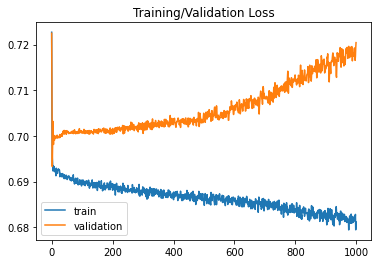

In [22]:
# Visualize the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Training/Validation Loss');
# Evaluate the model >> model.metrics_names
#print(f'{model.metrics_names}: {model.evaluate(Bitcoin_train, y_train , verbose=1)}')
plt.show()

# Save accuracies

In [23]:
y_prob = model.predict(X_test)
y_pred = list(map(lambda x: 0 if x<0.49 else 1, y_prob))

In [24]:
# Computing Accuracy, Precision and Recall
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.4934579439252336


In [26]:
df_prediction = pd.read_csv("../data/model_accuracy_IBM.csv", index_col = False)
df_prediction =  df_prediction.drop(columns=["Unnamed: 0"])
df_prediction

,LogReg_pred,LogReg_accuracy,LogReg_prob,LGBM_pred,LGBM_accuracy,LGBM_prob,y,kNN_pred,kNN_accuracy,kNN_prob,...,RF_pred,RF_accuracy,RF_prob,SVC_pred,SVC_accuracy,SVC_prob,LSTM_price_accuracy,RNN_pred,RNN_accuracy,RNN_prob
0,0,0.48785,0.499232,0,0.48972,0.482038,0,0,0.508411,0.5,...,0,0.525234,0.422360,1,0.492523,0.517458,0.857009,0,0.493458,0.488459
1,1,0.48785,0.504807,1,0.48972,0.516175,1,0,0.508411,0.5,...,1,0.525234,0.504748,1,0.492523,0.517960,0.857009,1,0.493458,0.536730
2,1,0.48785,0.591117,1,0.48972,0.526401,1,0,0.508411,0.5,...,1,0.525234,0.635901,1,0.492523,0.526435,0.857009,1,0.493458,0.626067
3,1,0.48785,0.595272,1,0.48972,0.515859,1,1,0.508411,1.0,...,1,0.525234,0.800362,1,0.492523,0.527133,0.857009,1,0.493458,0.636652
4,1,0.48785,0.590655,1,0.48972,0.515859,1,1,0.508411,1.0,...,1,0.525234,0.617615,1,0.492523,0.526471,0.857009,1,0.493458,0.635811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,1,0.48785,0.543262,1,0.48972,0.536454,1,0,0.508411,0.5,...,1,0.525234,0.669753,1,0.492523,0.522732,0.857009,1,0.493458,0.548477
1066,1,0.48785,0.570132,1,0.48972,0.521491,1,1,0.508411,1.0,...,1,0.525234,0.765041,1,0.492523,0.524813,0.857009,1,0.493458,0.591784
1067,1,0.48785,0.542180,1,0.48972,0.537546,0,1,0.508411,1.0,...,1,0.525234,0.747523,1,0.492523,0.522923,0.857009,1,0.493458,0.559243
1068,1,0.48785,0.569741,1,0.48972,0.521313,1,0,0.508411,0.5,...,1,0.525234,0.580589,1,0.492523,0.524824,0.857009,1,0.493458,0.595539


In [27]:
df_prediction["RNN_pred"] = y_pred
df_prediction["RNN_accuracy"] = [accuracy for x in range(len(y_pred))]
df_prediction["RNN_prob"] = y_prob

In [28]:
df_prediction

,LogReg_pred,LogReg_accuracy,LogReg_prob,LGBM_pred,LGBM_accuracy,LGBM_prob,y,kNN_pred,kNN_accuracy,kNN_prob,...,RF_pred,RF_accuracy,RF_prob,SVC_pred,SVC_accuracy,SVC_prob,LSTM_price_accuracy,RNN_pred,RNN_accuracy,RNN_prob
0,0,0.48785,0.499232,0,0.48972,0.482038,0,0,0.508411,0.5,...,0,0.525234,0.422360,1,0.492523,0.517458,0.857009,0,0.493458,0.488459
1,1,0.48785,0.504807,1,0.48972,0.516175,1,0,0.508411,0.5,...,1,0.525234,0.504748,1,0.492523,0.517960,0.857009,1,0.493458,0.536730
2,1,0.48785,0.591117,1,0.48972,0.526401,1,0,0.508411,0.5,...,1,0.525234,0.635901,1,0.492523,0.526435,0.857009,1,0.493458,0.626067
3,1,0.48785,0.595272,1,0.48972,0.515859,1,1,0.508411,1.0,...,1,0.525234,0.800362,1,0.492523,0.527133,0.857009,1,0.493458,0.636652
4,1,0.48785,0.590655,1,0.48972,0.515859,1,1,0.508411,1.0,...,1,0.525234,0.617615,1,0.492523,0.526471,0.857009,1,0.493458,0.635811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,1,0.48785,0.543262,1,0.48972,0.536454,1,0,0.508411,0.5,...,1,0.525234,0.669753,1,0.492523,0.522732,0.857009,1,0.493458,0.548477
1066,1,0.48785,0.570132,1,0.48972,0.521491,1,1,0.508411,1.0,...,1,0.525234,0.765041,1,0.492523,0.524813,0.857009,1,0.493458,0.591784
1067,1,0.48785,0.542180,1,0.48972,0.537546,0,1,0.508411,1.0,...,1,0.525234,0.747523,1,0.492523,0.522923,0.857009,1,0.493458,0.559243
1068,1,0.48785,0.569741,1,0.48972,0.521313,1,0,0.508411,0.5,...,1,0.525234,0.580589,1,0.492523,0.524824,0.857009,1,0.493458,0.595539


In [29]:
df_prediction.to_csv("../data/model_accuracy_IBM.csv")